<a href="https://colab.research.google.com/github/Yphy/ml_practice/blob/master/CNN_SPAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN으로 스팸 메일 분류하기

In [ ]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

데이터 다운

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin-1')

In [ ]:
data = data.iloc[:,:2]
data = data.rename(columns = {'v1':'spam','v2':'text'})
data

,spam,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
data.isnull().sum() #결측치 확인

spam    0
text    0
dtype: int64

In [ ]:
data.spam = data.spam.replace(['ham','spam'],[0,1])

In [ ]:
data.spam.value_counts()

0    4825
1     747
Name: spam, dtype: int64

In [ ]:
data.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Preprocessing

임베딩을 하기 전에 텍스트를 전처리하는 간단한 전처리함수를 생성하였다.

근데 스팸문자의 패턴을 추출하려하는데 특수문자를 제거하는게 과연 옳은 건지는 의문이긴 한데 일단 공백 제거하고 나이브하게 실행

In [ ]:
def preprocessing(x):
  x = x.strip() #앞뒤공백
  x = x.lower() #소문자
  x = re.sub('[-=+,.#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]',' ',x)
  pattern = re.compile(r'\s+') #중복띄어쓰기 제거
  x = re.sub(pattern,' ',x)
  return x

In [ ]:
def get_tokens(txt):
  tokens = txt.split()
  stop_words = set(stopwords.words('english'))
  tokens = [w for w in tokens if not w in stop_words]
  return tokens

In [ ]:
data.text = list(map(lambda x : preprocessing(x),data.text))
data.text = list(map(lambda x : get_tokens(x),data.text))
data.text[:5]

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
Name: text, dtype: object

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def create_tokenizers(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

def encode_docs(tokenizer, max_length, docs):
  encoded = tokenizer.texts_to_sequences(docs)
  padded = pad_sequences(encoded, maxlen=max_length, padding='post')
  return padded

In [ ]:
#train,test set 분리
from sklearn.model_selection import train_test_split
labels = data.spam
text = data.text
x_train, x_test, y_train, y_test = train_test_split(text,labels, test_size=0.2)

In [ ]:
x_test

4391                                  [new, years, plans]
1877    [pen, thing, beyond, joke, wont, biro, masters...
5074    [2nd, attempt, contract, u, weeks, top, prize,...
324                                             [problem]
5416    [slave, want, take, 2, 3, pictures, today, bri...
                              ...                        
3345      [u, welcome, caught, u, using, broken, english]
168     [great, escape, fancy, bridge, needs, lager, s...
6       [even, brother, like, speak, treat, like, aids...
1422    [congratulations, ur, awarded, either, å£500, ...
5225    [smile, pleasure, smile, pain, smile, trouble,...
Name: text, Length: 1115, dtype: object

13.417096701817366


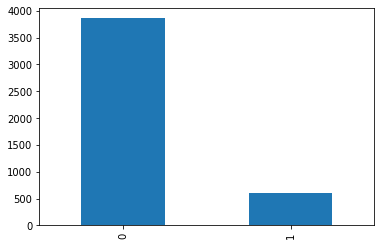

In [ ]:
y_train.value_counts().plot(kind='bar');
print(y_train.value_counts(0)[1] / (y_train.value_counts(0)[0] + y_train.value_counts(0)[1])*100)

In [ ]:
#token들을 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_sequences(x_test)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

## Padding

텍스트 최대 길이: 77
텍스트 평균 길이: 9.506843168050258


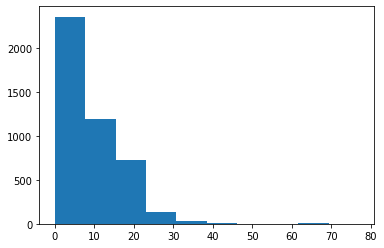

In [ ]:
print('텍스트 최대 길이:',max(len(x) for x in x_train))
print('텍스트 평균 길이:', sum(map(len,x_train))/len(x_train))
plt.hist([len(x) for x in x_train])
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.03522548799641


In [ ]:
x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)

In [ ]:
x_train[4]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  140,  176,  810, 1107, 1292], dtype=int32)

## Modeling


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Embedding, Dropout, Conv1D, GlobalMaxPool1D, Dense , Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
vocab_size = 10000
max_len = 30

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 30, 100)           1000000   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 28, 32)            9632      
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 32)                0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size,100,input_length = max_len))
# model.add(Conv1D(filters=32, kernel_size=3, activation ='relu'))
# model.add(GlobalMaxPool1D())
# model.add(Flatten())
# model.add(Dense(10,activation = 'relu'))
# model.add(Dropout(0.3))
# model.add(Dense(1,activation = 'sigmoid'))

In [ ]:
def CNN_model(max_len):
  model = Sequential()
  model.add(Embedding(vocab_size,100,input_length = max_len))
  model.add(Conv1D(filters = 32, kernel_size = 3, activation = 'relu'))
  model.add(GlobalMaxPool1D())
  # model.add(Conv1D(filters = 64, kernel_size = 3, activation = 'relu'))
  # model.add(GlobalMaxPool1D())
  model.add(Flatten())
  model.add(Dense(10,activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1,activation = 'sigmoid'))

  model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  model.summary()
  return model


In [ ]:
model = CNN_model(30)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(x_train, y_train, epochs = 10, validation_data = (x_test, y_test), callbacks=[es, mc])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 30, 100)           1000000   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 28, 32)            9632      
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 32)                0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                330       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)               

In [ ]:

print("\n 테스트 정확도: %.4f" % (model.evaluate(x_test, y_test)[1]))

35/35 [==============================] - 0s 2ms/step - loss: 0.1041 - accuracy: 0.9848

 테스트 정확도: 0.9848
